## Comparing Value and Likelihood Function to calculate Regret

In [1]:
import os

curr_dir = os.path.split(os.getcwd())[1]
if curr_dir != "irl-environment-design":
    os.chdir("..")

In [2]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np

from src.utils.make_environment import transition_matrix, Environment, insert_walls_into_T
from src.utils.visualization import plot_posterior_distribution, plot_environment, plot_trajectories, plot_log_likelihood
from src.utils.constants import ParamTuple
from src.utils.optimization import soft_q_iteration
from src.utils.inference.rollouts import generate_n_trajectories

np.set_printoptions(linewidth=160, precision=2)

Create Environment

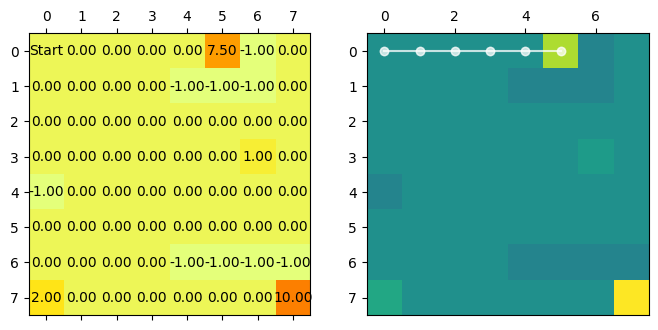

In [3]:
# 0. Setup
## 0.1 Setup the experiment
n_env_samples = 15
n_posterior_samples = 10
n_traj_per_sample = 2

## 0.2 Setup the environment
N, M = 8,8
n_states, n_actions = N * M, 4

# TODO describe world
agent_R = np.zeros((N, M))
agent_R[0, M-3] = 7.5
agent_R[3, M-2] = 1
agent_R[N-1, 0] = 2
agent_R[N-1, M-1] = 10
agent_R[4, 0] = -1

agent_R[1, M-4] = -1
agent_R[1, M-3] = -1
agent_R[1, M-2] = -1
agent_R[0, M-2] = -1

agent_R[N-2, M-4] = -1
agent_R[N-2, M-3] = -1
agent_R[N-2, M-2] = -1
agent_R[N-2, M-1] = -1

# Start by making the agent we want to learn the policy of
agent_p = 0.9
agent_gamma = 0.8
p_true=1

agent_R = agent_R.flatten()
goal_states = np.where(agent_R != 0)[0]

true_params = ParamTuple(agent_p, agent_gamma, agent_R)

n_samples_MC = 1_000
n_burnin_MC = 500

# Generate 2 trajectories in the env starting environment
wall_states = []
T_true = transition_matrix(N, M, p=p_true, absorbing_states=goal_states)
T_agent = transition_matrix(N, M, p=agent_p, absorbing_states=goal_states)
agent_policy = soft_q_iteration(agent_R, T_agent, gamma=agent_gamma, beta=1000)

env_agent = Environment(N=N,M=M,T_true=T_true,wall_states=wall_states, R_sample_mean=None, start_state=0, n_walls=None)

# Generate trajectories
trajectories = generate_n_trajectories(
    env_agent.T_true,
    agent_policy,
    goal_states,
    n_trajectories=2,
)

expert_trajectories_1 = [(env_agent, trajectories)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plot_environment(
    agent_R.reshape(N, M),
    env_agent.wall_states,
    start_state=(env_agent.start_state // M, env_agent.start_state % M),
    ax=ax1,
)

# Show the trajectories
plot_trajectories(N, M, trajectories, agent_R, ax=ax2)

# Remove the colorbar from the second plot
ax2.get_images()[0].colorbar.remove()

Posterior after two expert demonstrations in first environment

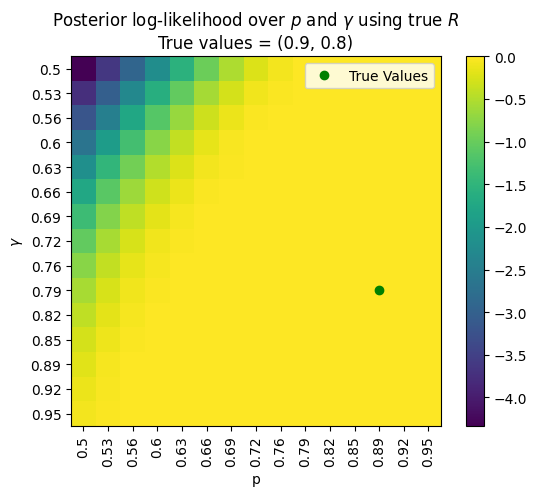

In [4]:
plot_log_likelihood(param_values=true_params, expert_trajectories=expert_trajectories_1, goal_states=goal_states)

## Create Candidate Environments, insert a wall state in each goal state

We consider all permutations of the goal states, so if there are $N$ goal states, we insert 2^N different wall combinations.

In [5]:
def powerset(s):
    pset = []
    x = len(s)
    for i in range(2 << x):
        pset.append([s[j] for j in range(x) if (i & (1 << j))])
    return pset

#insert wall in each goal state s.t. expert can no longer execute strategy
_goal_states_list = list(np.where(agent_R > 0)[0])
_goal_states_list = powerset(_goal_states_list)
#create candidate environment
candidate_envs = [Environment(N=N,M=M,T_true=T_true,wall_states=wall_states, R_sample_mean=None, start_state=0, n_walls=None)
for _ in range(len(_goal_states_list))]

for idx, candidate_env in enumerate(candidate_envs):

    #update T
    _T = insert_walls_into_T(candidate_env.T_true, wall_indices=[_goal_states_list[idx]])
    candidate_env.T_true = _T

    #append wall to list of walls of that environment
    candidate_env.wall_states = _goal_states_list[idx]

Calculate potential Posterior in candidate environment if we had 2 expert trajectories in that environment.

In [6]:
def plot_posterior_for_env(env: Environment):

    print("Regret: ", env.regret)
    print("Wall States: ", env.wall_states)

    T_true = transition_matrix(N, M, p=p_true, absorbing_states=goal_states)
    T_true = insert_walls_into_T(T_true, wall_indices=env.wall_states)
    env.T_true = T_true
    T_agent = transition_matrix(N, M, p=agent_p, absorbing_states=goal_states)
    T_agent = insert_walls_into_T(T_agent, wall_indices=env.wall_states)
    agent_policy = soft_q_iteration(agent_R, T_agent, gamma=agent_gamma, beta=1000)


    # Generate trajectories
    trajectories = generate_n_trajectories(
        env.T_true, #shouldnt this be T_true?
        agent_policy,
        goal_states,
        n_trajectories=2,
    )

    expert_trajectories_1 = [(env, trajectories)]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    plot_environment(
        agent_R.reshape(N, M),
        env.wall_states,
        start_state=(env.start_state // M, env.start_state % M),
        ax=ax1,
    )

    # Show the trajectories
    plot_trajectories(N, M, trajectories, agent_R, ax=ax2)

    # Remove the colorbar from the second plot
    ax2.get_images()[0].colorbar.remove()

    plot_log_likelihood(param_values=true_params, expert_trajectories=expert_trajectories_1, goal_states=goal_states)

## Calculate likelihood and value based regret for this environment

In [7]:
from src.utils.inference.sampling import bayesian_parameter_learning
from src.utils.environment_design import environment_search

posterior_samples_1 = bayesian_parameter_learning(expert_trajectories=expert_trajectories_1, 
                                                  sample_size=n_samples_MC, 
                                                  goal_states=goal_states, 
                                                  n_states=n_states)
posterior_samples_1 = posterior_samples_1[-100:]

Calculate the regret of the environments using the value function

In [8]:
envs_value = environment_search(
    N=N, M=M, goal_states=goal_states, posterior_samples=posterior_samples_1,
    n_traj_per_sample=2, candidate_envs=candidate_envs, how="value", agent_R=agent_R)

Evaluating candidate environments using value: 100%|██████████| 32/32 [04:46<00:00,  8.95s/it, highest_regret=0.161]


Calculate the regret of the environments using the likelihood function

In [8]:
envs_likelihood = environment_search(
    N=N, M=M, goal_states=goal_states, posterior_samples=posterior_samples_1,
    n_traj_per_sample=2, candidate_envs=candidate_envs, how="likelihood", agent_R=agent_R)

Evaluating candidate environments using likelihood:  97%|█████████▋| 31/32 [09:13<00:17, 17.86s/it, highest_regret=0.98]


Top 5 environments according to value

Regret:  0.1607736163018859
Wall States:  [56, 63]


Regret:  0.1607736163018859
Wall States:  [56, 63]
Regret:  0.1607720158228529
Wall States:  [30, 56, 63]
Regret:  0.1607720158228529
Wall States:  [30, 56, 63]
Regret:  0.16076356404778508
Wall States:  [63]


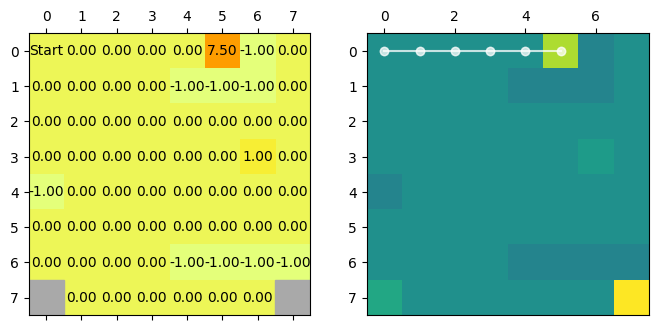

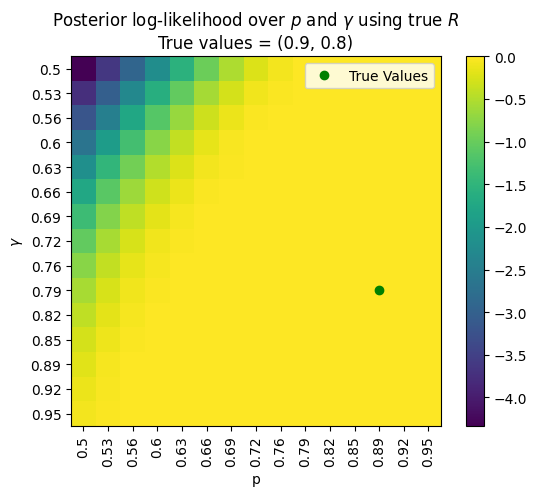

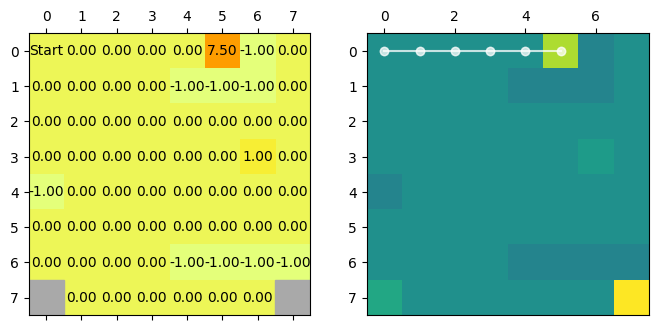

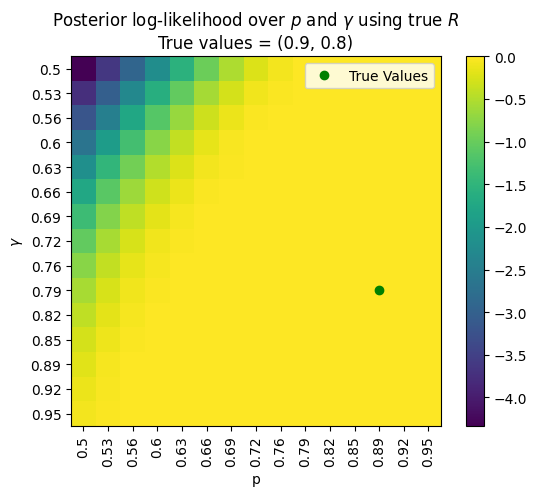

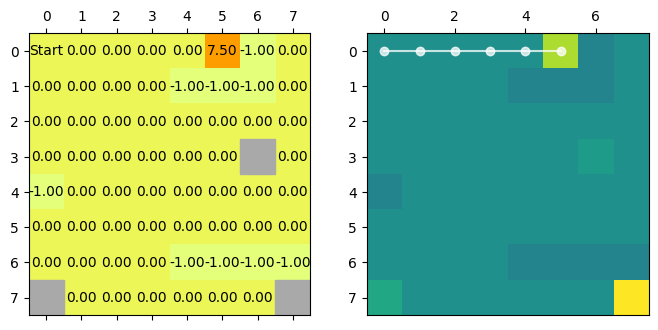

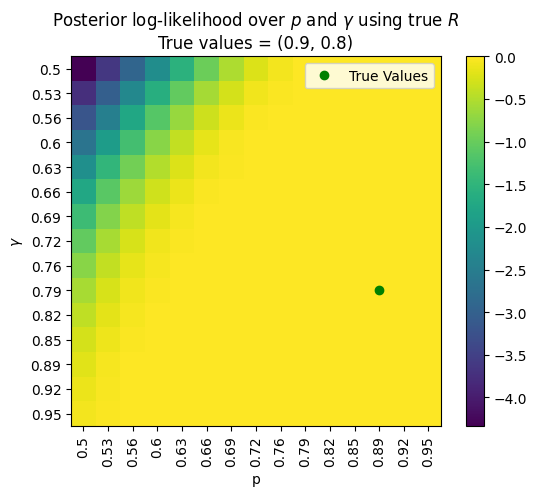

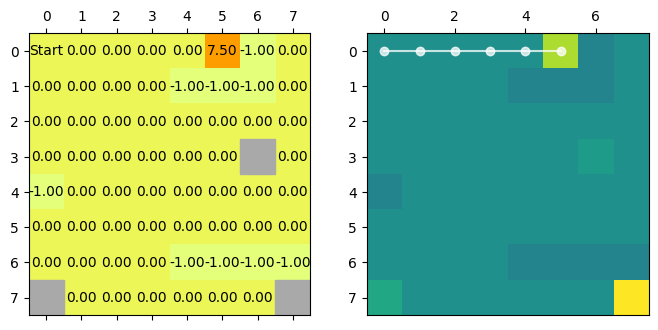

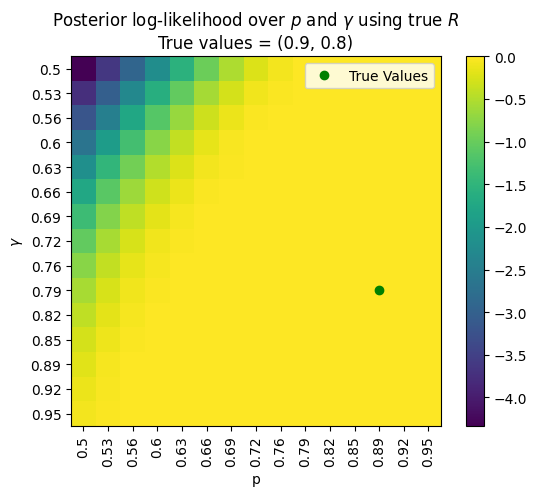

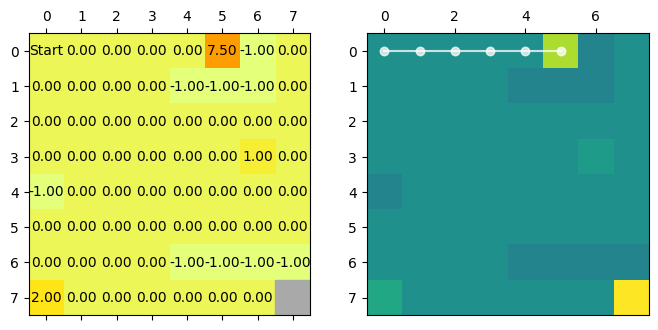

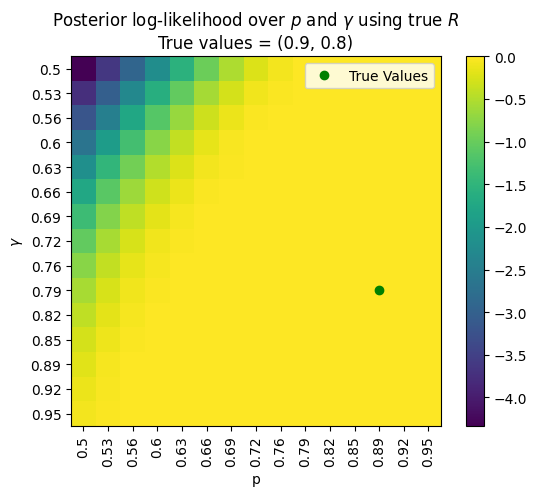

In [9]:
for env in envs_value[:5]:
    plot_posterior_for_env(env)

Top 5 environments according to likelihood

In [ ]:
for env in envs_likelihood[:5]:
    plot_posterior_for_env(env)

Bottom 5 environments, value

Regret:  0.11929203431513291
Wall States:  [5, 30]


Regret:  0.11839858502278777
Wall States:  [5, 56]
Regret:  0.11839858502278777
Wall States:  [5, 56]
Regret:  0.11829235279474398
Wall States:  [5]
Regret:  0.11829235279474398
Wall States:  [5]


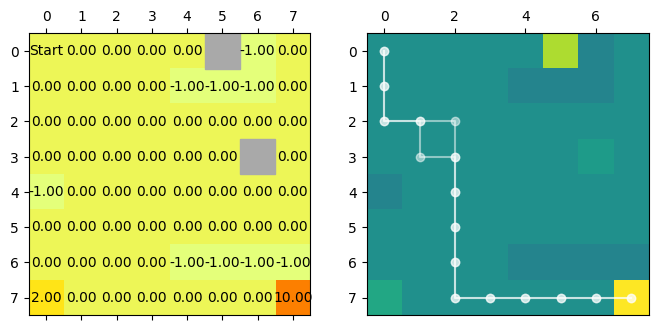

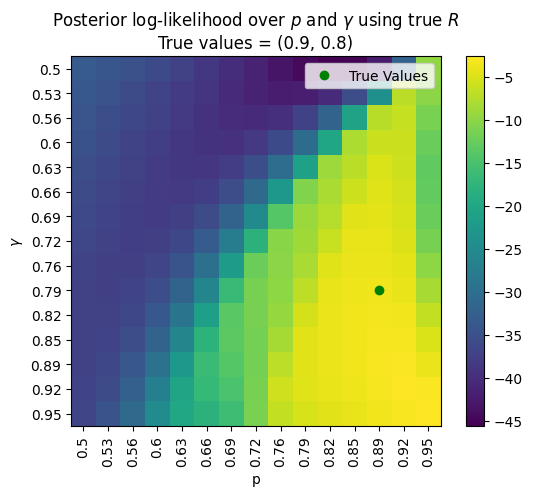

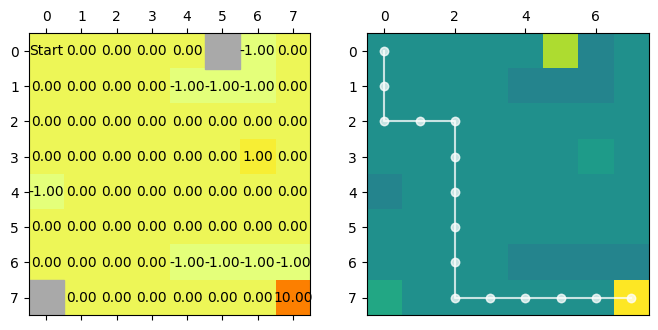

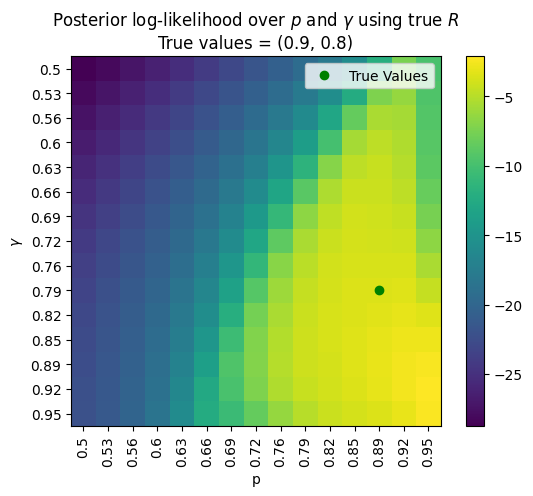

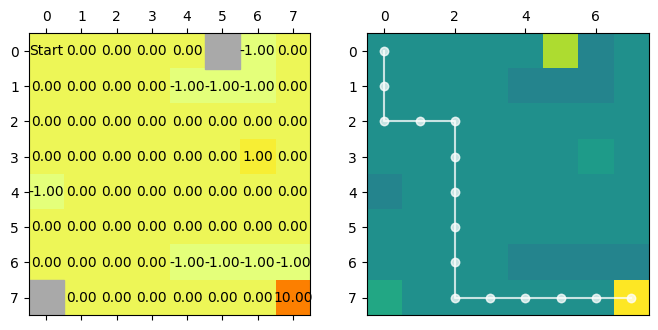

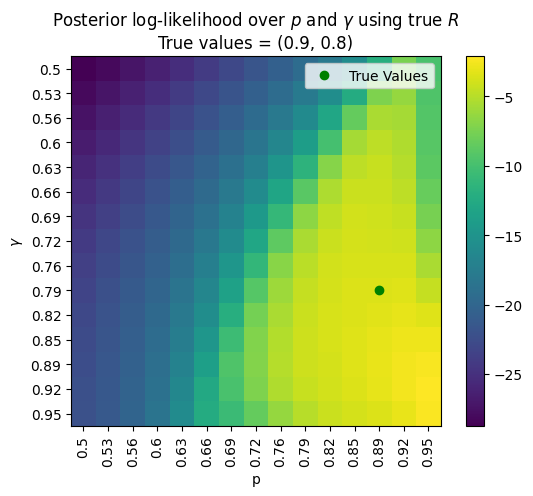

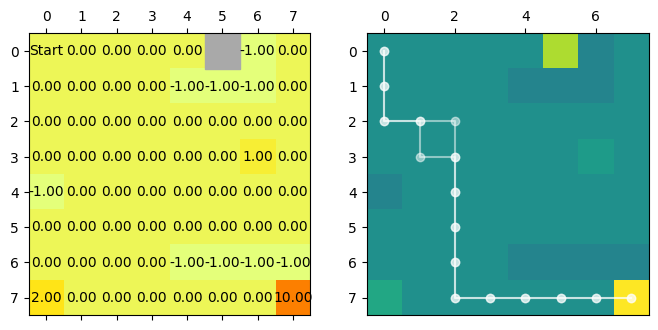

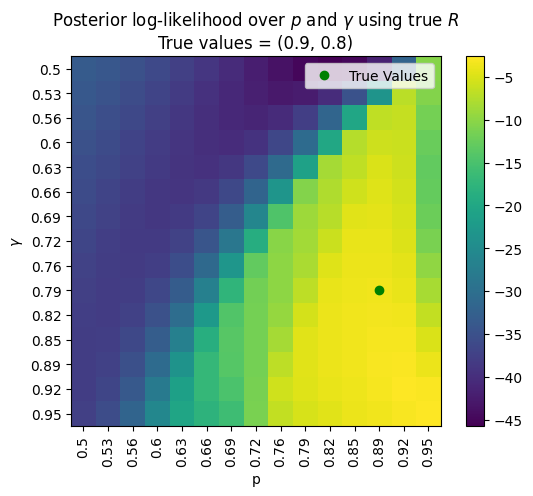

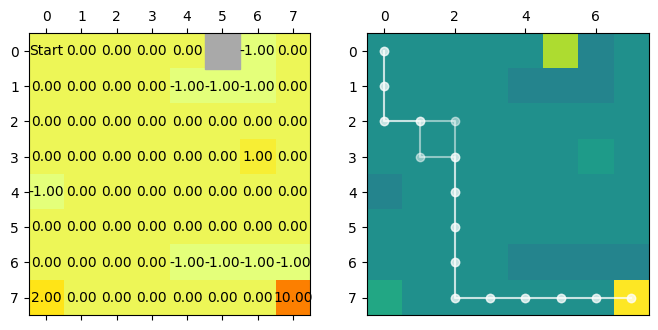

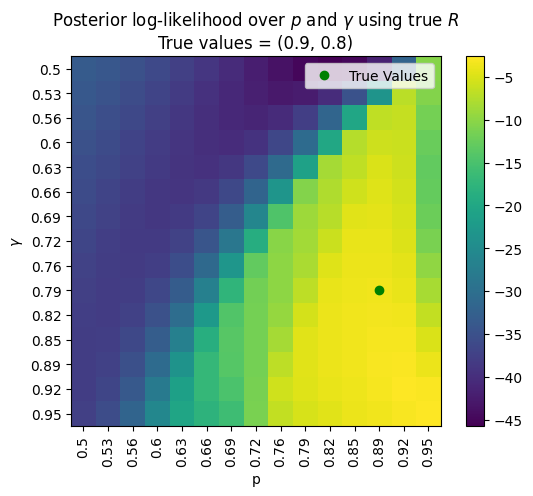

In [10]:
for env in envs_value[-5:]:
    plot_posterior_for_env(env)

Bottom 5 environments according to likelihood

In [ ]:
for env in envs_likelihood[-5]:
    plot_posterior_for_env(env)